## Addendum 

Addendum to project 1: 
Linear regression on preferred work starting time, based on the techniques presented in the lessons. 

Comparable to the "Project_1" Jupyther notebook, this notebook consists of
* loading necessary libraries
* reading in the data
* handling NANs
* adding additional columns (with converted values)
* splitting the dataset into students and professionals

Afterwards, comparably to the procedure in the lessons, the dataset is processed in the following way:
* Splitting in feature and response set
* Handling NANs in numerical and categorial columns
* Splitting in test and train dataset
* Training a LinearRegression model (based on the sklearn package)
* Predicting responses for the test set
* Scoring the result
This process is repeated for a growing number of columns and the model with the best score is given back. 

At last, the coefficients of the "best" linear model are extracted and printed in a table. 

Surprising for me was the poor result in comparison to my manual analysis on several features using descriptive statistics (see notebook Project_1). Also, features with big correlation to WorkStart (e.g. Salary, as shown in Project_1) are not visible in the top coefficients. 

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [2]:
#Load dataset
df = pd.read_csv("./survey_results_public.csv")

In [3]:
#Handle NANs
df = df.dropna(subset=["WorkStart"], axis=0)

In [4]:
####################
#Data conversions

#Column Z_StartingHour:
#Converting column WorkStart to integer
def parseTime(str1):
    time=0
    if(str1=="Midnight"):
        time=0
    elif(str1=="Noon"):
        time=12
    else:
        hours=int(str1.split(":")[0])
        suffix=str1.split(" ")[1]
        if(suffix=="AM"):
            time=hours
        else:
            time=hours+12
    return time
df=df.assign(Z_StartingHour=df.WorkStart.apply(parseTime))

#Column Z_StartingNorm:
#Calculating the distance between the preferred starting time and 9 am, 
#which is the center of the distribution of the preferred starting times
#(e.g. 8 am = -1, 9 am = 0, 10 am = 1, ...)
def convertTime1(int1):
    ret=0
    if(4<=int1 and int1<=20):
        ret=int1-9
    else:
        ret=int1-9-24
    return ret
df=df.assign(Z_StartingNorm=df.Z_StartingHour.apply(convertTime1))

#Column Z_StartingSR:
#Calculating the preferred work starting time based on 4 am (average start of civil twilight in summer)
#(e.g. 4 am = 0, 5 am = 1, ..., 3 am = 23)
def convertTime2(int1):
    ret=0
    if(4<=int1):
        ret=int1-4
    else:
        ret=int1-4+24
    return ret
df=df.assign(Z_StartingSR=df.Z_StartingHour.apply(convertTime2))

In [5]:
#Dividing the survey participants into two groups: Students and professionals

df_profs=df[df["Professional"].isin(["Professional developer", "Professional non-developer who sometimes writes code"])]
df_studs=df[df["Professional"].isin(["Student"])]

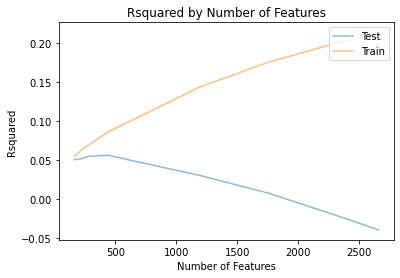

In [6]:
####################
#Addendum: 
#Are there dependencies between the preferred starting hour and any other feature of the dataset 
#(beyond the already analyzed ones)?

#This analysis uses an adapted version of the coding used in the lessons. 
#As it's only an addendum to my solution and just for curiosity (and because I want to ask a question later on), 
#so I think this is ok here. 
def find_optimal_lm_mod_2(X, y, cutoffs, test_size = 0.3, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

#Regression on preferred starting hour
#Separate into feature set and response
df_profs_y=df_profs["Z_StartingSR"]
df_profs_x=df_profs.drop(["Respondent", "WorkStart", "ExpectedSalary", "Z_StartingHour", "Z_StartingNorm", "Z_StartingSR"], axis=1)

#Handle NANs in numerical and categorical columns
cat_cols=df_profs_x.select_dtypes(include=['object']).columns
num_cols=list(set(df_profs_x.columns)-set(cat_cols))

for i in num_cols:
    df_profs_x[i].fillna((df_profs_x[i].mean()), inplace=True)

for i in cat_cols:
    df_profs_x=pd.concat([df_profs_x.drop(i, axis=1), pd.get_dummies(df_profs_x[i], prefix=i, prefix_sep="_", drop_first=True)], axis=1)    

#Find best model
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod_2(df_profs_x, df_profs_y, cutoffs)

In [7]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
15,University_No,-0.536562,0.536562
14,Country_United States,-0.493187,0.493187
12,Country_India,0.470095,0.470095
16,"University_Yes, full-time",-0.380039,0.380039
313,EquipmentSatisfiedStorage_Very satisfied,0.329907,0.329907
373,StackOverflowJobListing_Haven't done at all,0.329787,0.329787
87,BoringDetails_Strongly agree,0.323879,0.323879
280,OtherPeoplesCode_Strongly agree,0.321150,0.321150
17,"University_Yes, part-time",-0.319739,0.319739
385,StackOverflowAnswer_At least once each week,-0.311955,0.311955
